## Useful code for processing test data

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

### Time test for files

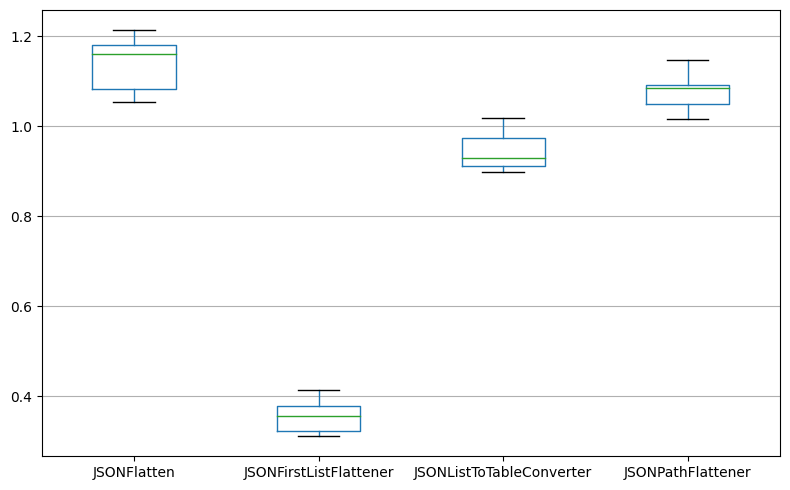

In [2]:
TEST_FILES = [
    ("time/files/JSONFlatten", "JSONFlatten"),
    ("time/files/JSONFirstListFlattener", "JSONFirstListFlattener"),
    ("time/files/JSONListToTableConverter", "JSONListToTableConverter"),
    ("time/files/JSONPathFlattener", "JSONPathFlattener"),
]

DUMMY_FILE = "time/files/JSONDummy"
with open(DUMMY_FILE) as file:
    dummy_values = np.array(file.read().split()).astype(float)

df_time_duration = pd.DataFrame()

for filename, plot_name in TEST_FILES:
    values = np.array([])
    with open(filename) as file:
        unclean_values = np.array(file.read().split()).astype(float)
        values = unclean_values - dummy_values

        mask = np.ones(len(values), dtype=bool)
        mask[np.argmin(values)] = mask[np.argmax(values)] = False
        values = values[mask]

    df_time_duration[plot_name] = pd.DataFrame(values)

axes = df_time_duration.boxplot(figsize=(8,5), grid=False)
axes.grid(axis='y')
plt.tight_layout()
plt.show()

### Time measures with ballooner

In [3]:
MAX_MEASURES = 12
DIRECTORY_PATH = "time/"
txt_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.txt"))
files = [os.path.basename(file) for file in txt_files]

main_time_dict = {}
""" example structure
{
    ('nasa', '100000', '15000'): {
        'json_dummy': [80.9, 75.025, 77.25, 56.425],
        'json_first_list_flattener': [81.92, 70.76, 76.575, 58.025, 77.8, 68.9]
    },
    ('nasa', '1000000', '12000'): {
        'json_dummy': [78.46, 90.97, 80.784, 88.621]
    }
}
"""

for filename in files:
    file_tags = filename.split("-")
    time_key = (file_tags[0], file_tags[1], file_tags[2]) # dataset, dataset_size and ballooning_loop_size
    flatter_key = file_tags[3] # flatter_method

    if time_key not in main_time_dict:
        main_time_dict[time_key] = {}

    with open(DIRECTORY_PATH + filename) as file:
        data = np.array(file.read().split()).astype(float)
        if len(data) > MAX_MEASURES:
            data = data[-MAX_MEASURES:]  # Take only the last 12 measures
        main_time_dict[time_key][flatter_key] = data

print(f"Keys: {main_time_dict.keys()}")

def draw_time_plot(key: tuple):
    if key not in main_time_dict.keys():
        print(f"Key {key} not found!")
        return

    measurements = main_time_dict[key].copy()
    DUMMY_KEY = "json_dummy.txt"
    if DUMMY_KEY not in measurements.keys():
        print(f"DUMMY_KEY not found!")
        return

    dummy_values = measurements[DUMMY_KEY]
    measurements.pop(DUMMY_KEY)

    if (dummy_values is None or len(dummy_values) < 1):
        print("No dummy measures!")
        return

    df_time_duration = pd.DataFrame()
    for method, time in measurements.items():
        unclean_values = np.array(time).astype(float)
        while len(dummy_values) < len(unclean_values):
            dummy_values = np.append(dummy_values, dummy_values[-1])

        values = unclean_values - dummy_values[:len(unclean_values)]

        mask = np.ones(len(values), dtype=bool)
        mask[np.argmin(values)] = mask[np.argmax(values)] = False
        values = values[mask]

        print(values)
        df_time_duration[method] = pd.DataFrame(values)
    
    axes = df_time_duration.boxplot(figsize=(8,5), grid=False)
    axes.grid(axis='y')
    plt.tight_layout()
    plt.show()


Keys: dict_keys([('nasa', '100000', '1000'), ('nasa', '100000', '5000')])


[-0.21  -0.505 -0.317 -0.282 -0.306  0.051 -0.282 -0.191 -0.259]
[0.543 0.453 0.523 0.875 0.592 1.023 0.569 0.717]
[-0.251 -0.456 -0.486 -0.246 -0.326  0.059 -0.249 -0.211 -0.711]
[-0.095 -0.342 -0.527 -0.475 -0.238  0.263 -0.445  0.16 ]


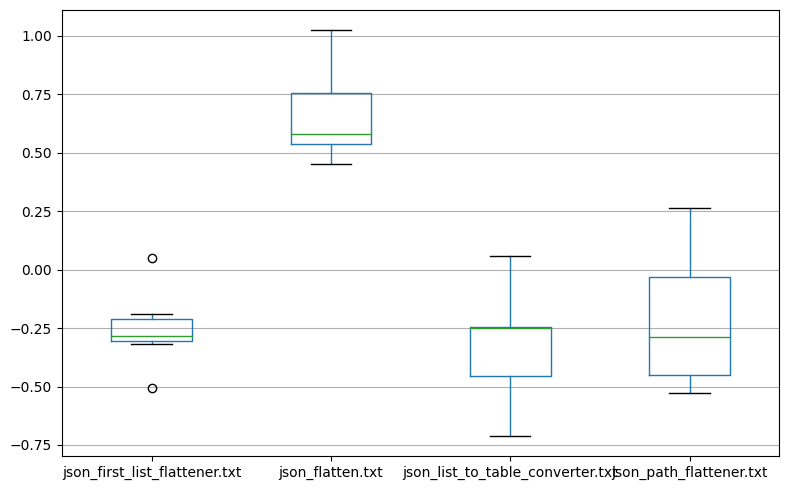

In [4]:
draw_time_plot(('nasa', '100000', '5000'))